In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from matplotlib.patches import Patch
import ast

In [29]:
# Define paths
# stg_output_trajectory = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/atherosclerosis_hsa05417/stg_output"
# trajectory_dir = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/atherosclerosis_hsa05417/text_files/cell_trajectories"

stg_output_trajectory = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/george_hiv_hsa05417/stg_output"
trajectory_dir = "/home/emoeller/github/scBONITA2/scBONITA_output/trajectories/george_hiv_hsa05417/text_files/cell_trajectories"


# Load state library
state_library_df = pd.read_csv(f"{stg_output_trajectory}/state_library.csv")

# Extract gene names from a sample trajectory file
trajectory_files = [f for f in os.listdir(trajectory_dir) if f.endswith('.csv')]
sample_trajectory = os.path.join(trajectory_dir, trajectory_files[0])

gene_names = []
with open(sample_trajectory, 'r') as f:
    for line in f:
        gene_name = line.strip().split(',')[0]
        gene_names.append(gene_name)

# Load GraphML graph
graphml_path = f"{stg_output_trajectory}/stg_graph_with_similarity.graphml"
G = nx.read_graphml(graphml_path)

# Identify attractors from GraphML
attractor_nodes = []
for node in G.nodes():
    node_data = G.nodes[node]
    if str(node_data.get('is_attractor', 'false')).lower() == 'true':
        attractor_size = int(node_data.get('attractor_size', 0))
        state_str = node_data.get('state', '')
        attractor_nodes.append({
            'state_id': int(node),
            'attractor_size': attractor_size,
            'state': state_str
        })

attractor_nodes_df = pd.DataFrame(attractor_nodes).sort_values('attractor_size', ascending=False)
attractors = state_library_df[state_library_df['is_attractor'] == True].sort_values('cells_reaching', ascending=False)

print(f"Loaded {len(state_library_df)} states, {len(gene_names)} genes")
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Found {len(attractor_nodes_df)} attractors\n")
print("Top 5 attractors by cell count:")
print(attractor_nodes_df[['state_id', 'attractor_size']].head(5))

Loaded 14490 states, 102 genes
Graph: 14490 nodes, 14552 edges
Found 1500 attractors

Top 5 attractors by cell count:
      state_id  attractor_size
142       4751             117
512       4708              87
1441      4880              54
412       6257              53
1115      4896              52


In [30]:
def visualize_mean_trajectory_to_attractor(attractor_state_id, state_library_df, gene_names, trajectory_dir):
    """
    Visualizes the mean trajectory of all cells leading to a specific attractor.
    
    Parameters
    ----------
    attractor_state_id : int
        The state_id of the attractor to analyze
    state_library_df : pd.DataFrame
        DataFrame containing state library information
    gene_names : list
        List of gene names
    trajectory_dir : str
        Path to directory containing cell trajectory files
    """
    # Load cell-to-attractor mapping
    cell_attractor_df = pd.read_csv(f"{stg_output_trajectory}/cell_attractor_mapping.csv")
    
    # Find all cells that reach this attractor
    cells_to_attractor = cell_attractor_df[cell_attractor_df['attractor_state_id'] == attractor_state_id]
    cell_numbers = cells_to_attractor['cell_number'].values
    
    if len(cell_numbers) == 0:
        print(f"No cells reach attractor {attractor_state_id}")
        return None
    
    print(f"Found {len(cell_numbers)} cells reaching attractor {attractor_state_id}")
    
    # Load all trajectories for these cells
    all_trajectories = []
    
    for cell_num in cell_numbers:
        trajectory_file = os.path.join(trajectory_dir, f"cell_{cell_num}_trajectory.csv")
        
        if os.path.exists(trajectory_file):
            trajectory_data = []
            with open(trajectory_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    time_data = [int(i) for i in parts[1:]]  # Skip gene name
                    trajectory_data.append(time_data)
            
            # Convert to numpy array (genes x time_steps)
            trajectory_array = np.array(trajectory_data)
            all_trajectories.append(trajectory_array)
    
    if len(all_trajectories) == 0:
        print(f"No trajectory files found for cells reaching attractor {attractor_state_id}")
        return None
    
    # Stack all trajectories and compute mean across cells
    # Shape: (num_cells, num_genes, num_time_steps)
    stacked_trajectories = np.stack(all_trajectories, axis=0)
    
    # Calculate mean trajectory: (num_genes, num_time_steps)
    mean_trajectory = np.mean(stacked_trajectories, axis=0)
    
    # Create the heatmap
    fig = plt.figure(figsize=(8, 12))
    sns.heatmap(mean_trajectory, cmap='Greys', yticklabels=gene_names, xticklabels=True, vmin=0, vmax=1, cbar=False)
    
    # Get attractor info
    attractor_info = state_library_df[state_library_df['state_id'] == attractor_state_id]
    cells_reaching = attractor_info['cells_reaching'].values[0] if len(attractor_info) > 0 else len(cell_numbers)
    
    plt.title(f'Mean Trajectory to Attractor {attractor_state_id}\n({len(cell_numbers)} cells, {cells_reaching} total reaching)', fontsize=14)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Genes', fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='lightgrey', edgecolor='grey', label='Gene Inactive (0)'),
        Patch(facecolor='black', edgecolor='black', label='Gene Active (1)'),
        Patch(facecolor='grey', edgecolor='grey', label='Intermediate (0-1)')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", fontsize=10)
    
    plt.subplots_adjust(top=0.958, bottom=0.07, left=0.076, right=0.85, hspace=2, wspace=1)
    
    return fig

State 146 info from GraphML:
  Is attractor: True
  Attractor size: 7 cells
Found 7 cells reaching attractor 146


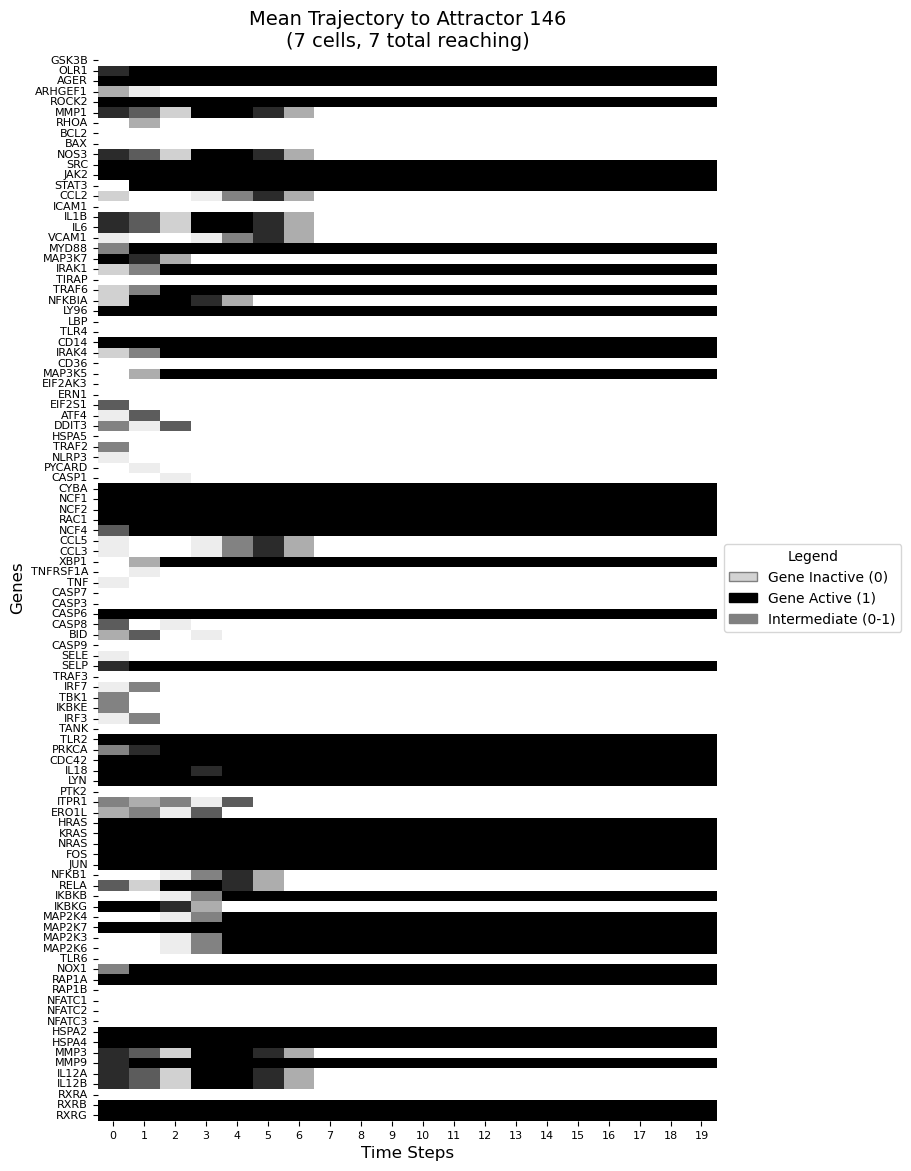

In [40]:
# Visualize mean trajectory to a specific attractor
# Change the state_id below to visualize a different attractor

specific_state_id = 146

if str(specific_state_id) in G.nodes():
    node_data = G.nodes[str(specific_state_id)]
    print(f"State {specific_state_id} info from GraphML:")
    print(f"  Is attractor: {node_data.get('is_attractor', 'false')}")
    print(f"  Attractor size: {node_data.get('attractor_size', 0)} cells")
    
    fig = visualize_mean_trajectory_to_attractor(specific_state_id, state_library_df, gene_names, trajectory_dir)
    if fig:
        plt.show()
else:
    print(f"State {specific_state_id} not found in GraphML graph")
    print(f"Try one of these attractor IDs: {attractor_nodes_df['state_id'].head(10).tolist()}")

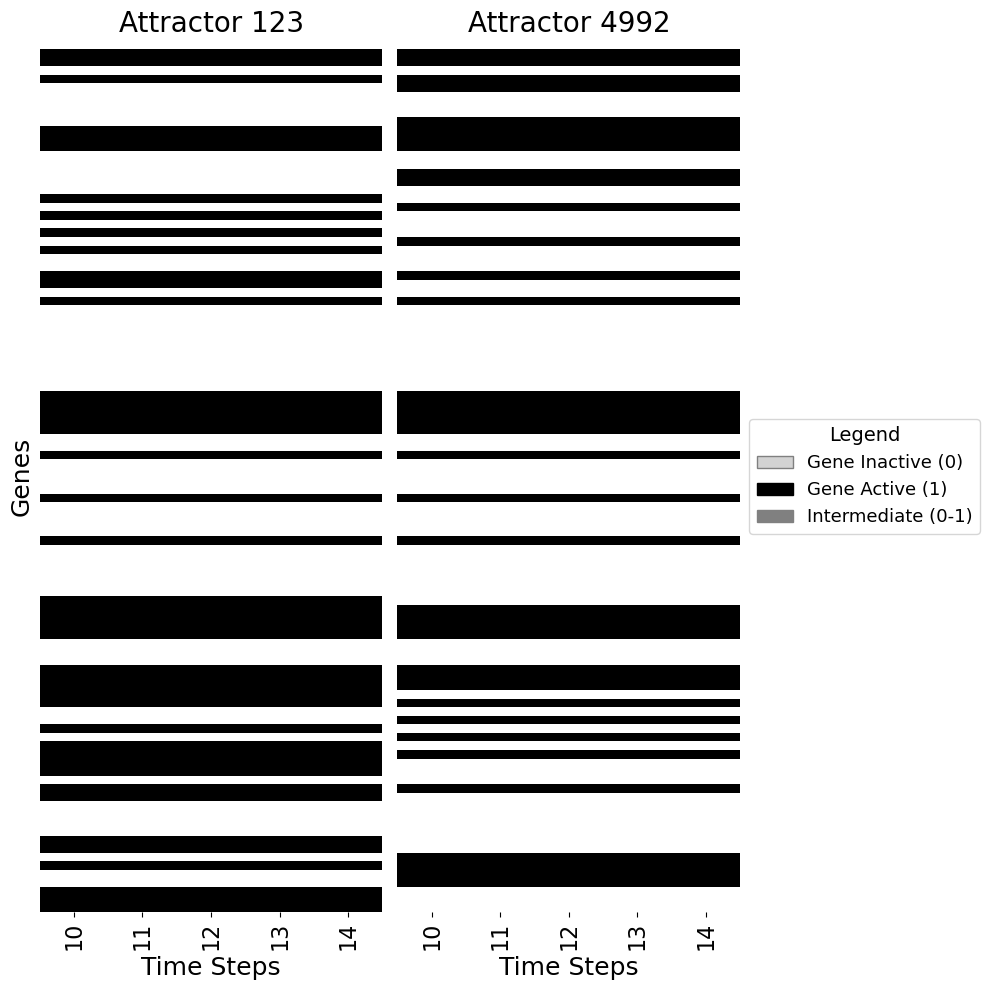

In [ ]:
def compare_attractor_trajectories(state_id_1, state_id_2, state_library_df, gene_names, trajectory_dir, stg_output_trajectory):
    """
    Visualizes and compares the mean trajectories of two attractors side by side.
    
    Parameters
    ----------
    state_id_1 : int
        The state_id of the first attractor
    state_id_2 : int
        The state_id of the second attractor
    state_library_df : pd.DataFrame
        DataFrame containing state library information
    gene_names : list
        List of gene names
    trajectory_dir : str
        Path to directory containing cell trajectory files
    stg_output_trajectory : str
        Path to STG output directory
    """
    fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
    
    for idx, state_id in enumerate([state_id_1, state_id_2]):
        # Load cell-to-attractor mapping
        cell_attractor_df = pd.read_csv(f"{stg_output_trajectory}/cell_attractor_mapping.csv")
        
        # Find all cells that reach this attractor
        cells_to_attractor = cell_attractor_df[cell_attractor_df['attractor_state_id'] == state_id]
        cell_numbers = cells_to_attractor['cell_number'].values
        
        if len(cell_numbers) == 0:
            print(f"No cells reach attractor {state_id}")
            continue
        
        # Load all trajectories for these cells
        all_trajectories = []
        for cell_num in cell_numbers:
            trajectory_file = os.path.join(trajectory_dir, f"cell_{cell_num}_trajectory.csv")
            
            if os.path.exists(trajectory_file):
                trajectory_data = []
                with open(trajectory_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        time_data = [int(i) for i in parts[1:]]
                        trajectory_data.append(time_data)
                
                trajectory_array = np.array(trajectory_data)
                all_trajectories.append(trajectory_array)
        
        if len(all_trajectories) == 0:
            print(f"No trajectory files found for attractor {state_id}")
            continue
        
        # Calculate mean trajectory
        stacked_trajectories = np.stack(all_trajectories, axis=0)
        mean_trajectory = np.mean(stacked_trajectories, axis=0)
        
        # Get attractor info
        attractor_info = state_library_df[state_library_df['state_id'] == state_id]
        cells_reaching = attractor_info['cells_reaching'].values[0] if len(attractor_info) > 0 else len(cell_numbers)
        
        # Plot on subplot
        ax = axes[idx]
        sns.heatmap(mean_trajectory, cmap='Greys', yticklabels=gene_names if idx == 0 else False,
                    xticklabels=True, vmin=0, vmax=1, ax=ax, cbar=False)
        ax.set_title(f"Attractor {state_id}", fontsize=20)
        ax.set_xlabel('Time Steps', fontsize=18)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
        if idx == 0:
            ax.set_ylabel('Genes', fontsize=18)
            
        # Add legend
    legend_elements = [
        Patch(facecolor='lightgrey', edgecolor='grey', label='Gene Inactive (0)'),
        Patch(facecolor='black', edgecolor='black', label='Gene Active (1)'),
        Patch(facecolor='grey', edgecolor='grey', label='Intermediate (0-1)')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), title="Legend", fontsize=13, title_fontsize=14)
    
    
    # plt.suptitle(f'Comparison: Attractor {state_id_1} vs Attractor {state_id_2}', fontsize=22, y=0.995)
    plt.tight_layout()
    
    return fig

attractor_1 = 123  # Your first attractor
attractor_2 = 4992    # Your second attractor
compare_attractor_trajectories(attractor_1, attractor_2, state_library_df, gene_names, trajectory_dir, stg_output_trajectory)
plt.show()

Comparing attractors 123 and 4992 (differences only)

Found 30 genes differing by >0.1
Range of differences: 0.111 to 1.000


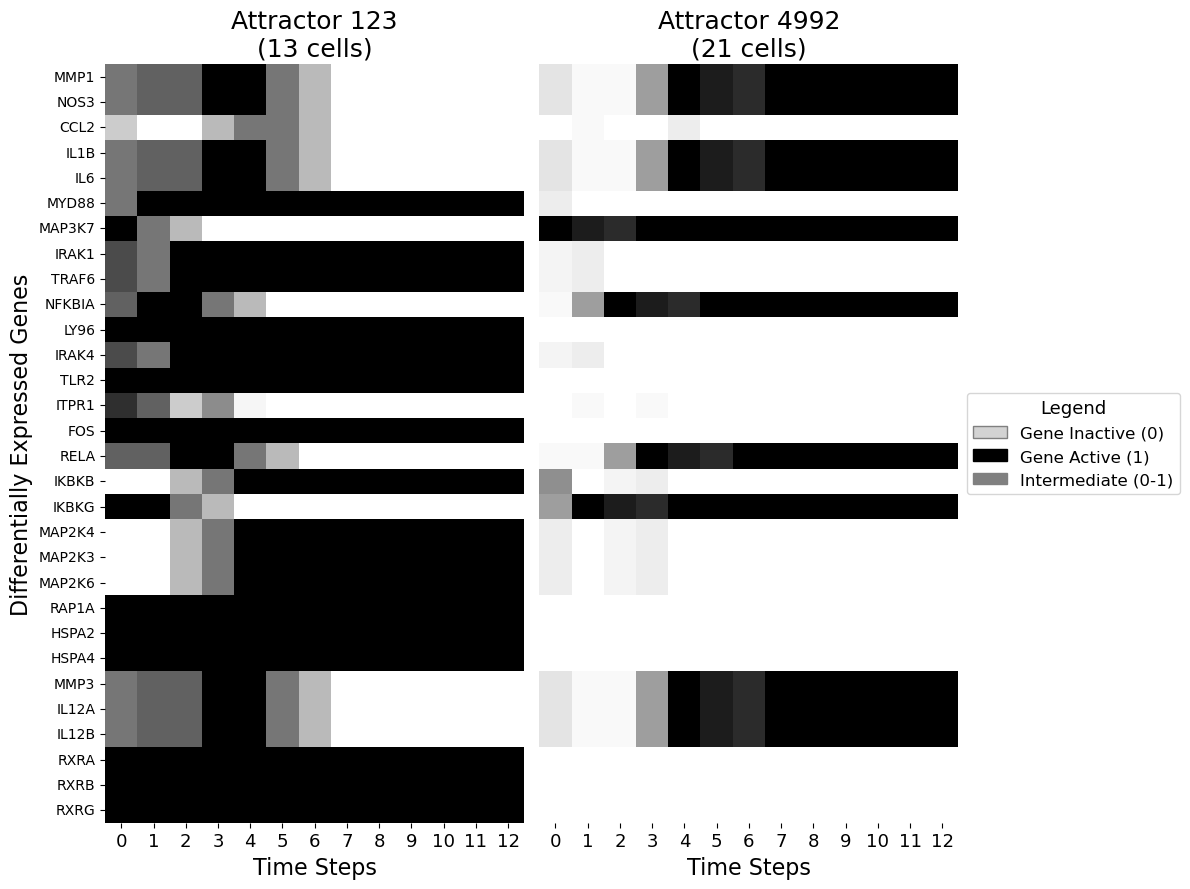

In [82]:
def compare_attractor_trajectories_differences(state_id_1, state_id_2, state_library_df, gene_names, trajectory_dir, stg_output_trajectory, difference_threshold=0.1):
    """
    Visualizes and compares only the genes that differ between two attractors.
    
    Parameters
    ----------
    state_id_1 : int
        The state_id of the first attractor
    state_id_2 : int
        The state_id of the second attractor
    state_library_df : pd.DataFrame
        DataFrame containing state library information
    gene_names : list
        List of gene names
    trajectory_dir : str
        Path to directory containing cell trajectory files
    stg_output_trajectory : str
        Path to STG output directory
    difference_threshold : float
        Minimum mean difference to consider genes as different (default: 0.1)
    """
    cell_attractor_df = pd.read_csv(f"{stg_output_trajectory}/cell_attractor_mapping.csv")
    
    # Load trajectories for both attractors
    mean_trajectories = []
    cell_counts = []
    
    for state_id in [state_id_1, state_id_2]:
        cells_to_attractor = cell_attractor_df[cell_attractor_df['attractor_state_id'] == state_id]
        cell_numbers = cells_to_attractor['cell_number'].values
        
        if len(cell_numbers) == 0:
            print(f"No cells reach attractor {state_id}")
            return None
        
        cell_counts.append(len(cell_numbers))
        
        # Load all trajectories for these cells
        all_trajectories = []
        for cell_num in cell_numbers:
            trajectory_file = os.path.join(trajectory_dir, f"cell_{cell_num}_trajectory.csv")
            
            if os.path.exists(trajectory_file):
                trajectory_data = []
                with open(trajectory_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split(',')
                        time_data = [int(i) for i in parts[1:]]
                        trajectory_data.append(time_data)
                
                trajectory_array = np.array(trajectory_data)
                all_trajectories.append(trajectory_array)
        
        if len(all_trajectories) == 0:
            print(f"No trajectory files found for attractor {state_id}")
            return None
        
        # Calculate mean trajectory
        stacked_trajectories = np.stack(all_trajectories, axis=0)
        mean_trajectory = np.mean(stacked_trajectories, axis=0)
        mean_trajectories.append(mean_trajectory)
    
    # Calculate absolute difference between trajectories for each gene
    diff_matrix = np.abs(mean_trajectories[0] - mean_trajectories[1])
    mean_diff_per_gene = np.mean(diff_matrix, axis=1)
    
    # Find genes that differ by more than threshold
    differing_gene_indices = np.where(mean_diff_per_gene >= difference_threshold)[0]
    
    if len(differing_gene_indices) == 0:
        print(f"No genes differ by more than {difference_threshold} between attractors")
        return None
    
    print(f"Found {len(differing_gene_indices)} genes differing by >{difference_threshold}")
    print(f"Range of differences: {mean_diff_per_gene[differing_gene_indices].min():.3f} to {mean_diff_per_gene[differing_gene_indices].max():.3f}")
    
    # Filter trajectories and gene names to only differing genes
    filtered_traj_1 = mean_trajectories[0][differing_gene_indices, :]
    filtered_traj_2 = mean_trajectories[1][differing_gene_indices, :]
    filtered_gene_names = [gene_names[i] for i in differing_gene_indices]
    
    # Create comparison plot
    fig, axes = plt.subplots(1, 2, figsize=(12, max(6, len(differing_gene_indices) * 0.3)), sharey=True)
    
    for idx, (filtered_traj, state_id, cell_count) in enumerate(zip([filtered_traj_1, filtered_traj_2], 
                                                                      [state_id_1, state_id_2],
                                                                      cell_counts)):
        ax = axes[idx]
        sns.heatmap(filtered_traj, cmap='Greys', yticklabels=filtered_gene_names,
                    xticklabels=True, vmin=0, vmax=1, ax=ax, cbar=False)
        ax.set_title(f"Attractor {state_id}\n({cell_count} cells)", fontsize=18)
        ax.set_xlabel('Time Steps', fontsize=16)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=13, rotation=0)
        ax.tick_params(axis='y', labelsize=10)
        if idx == 0:
            ax.set_ylabel('Differentially Expressed Genes', fontsize=16)
        else:
            ax.tick_params(axis='y', left=False)
        
        ax.set_xlim(0, 13)
    
    # Add legend
    legend_elements = [
        Patch(facecolor='lightgrey', edgecolor='grey', label='Gene Inactive (0)'),
        Patch(facecolor='black', edgecolor='black', label='Gene Active (1)'),
        Patch(facecolor='grey', edgecolor='grey', label='Intermediate (0-1)')
    ]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), 
               title="Legend", fontsize=12, title_fontsize=13)
    
    # plt.suptitle(f'Differentially Expressed Genes: Attractor {state_id_1} vs {state_id_2}', 
    #              fontsize=20, y=1.0)
    plt.tight_layout()
    
    return fig

# Example: Compare attractors showing only differences
attractor_1 = 123
attractor_2 = 4992
print(f"Comparing attractors {attractor_1} and {attractor_2} (differences only)\n")
fig = compare_attractor_trajectories_differences(attractor_1, attractor_2, state_library_df, gene_names, 
                                                   trajectory_dir, stg_output_trajectory, difference_threshold=0.1)
if fig:
    plt.show()


In [87]:

# Create dataframe of differential gene expression at timestep 20
cell_attractor_df = pd.read_csv(f"{stg_output_trajectory}/cell_attractor_mapping.csv")

# Get mean expression at timestep 20 for each attractor
attractor_expressions = {}

for state_id in [attractor_1, attractor_2]:
    cells_to_attractor = cell_attractor_df[cell_attractor_df['attractor_state_id'] == state_id]
    cell_numbers = cells_to_attractor['cell_number'].values
    
    # Load all trajectories for these cells
    all_trajectories_timestep20 = []
    for cell_num in cell_numbers:
        trajectory_file = os.path.join(trajectory_dir, f"cell_{cell_num}_trajectory.csv")
        
        if os.path.exists(trajectory_file):
            gene_values_timestep20 = []
            with open(trajectory_file, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    # Timestep 20 is at index 20 (parts[0] is gene name, parts[1] is timestep 0, etc.)
                    if len(parts) > 20:
                        gene_values_timestep20.append(float(parts[20]))
                    else:
                        # If timestep 20 doesn't exist, use the last available timestep
                        gene_values_timestep20.append(float(parts[-1]))
            
            all_trajectories_timestep20.append(gene_values_timestep20)
    
    # Calculate mean across cells for this attractor
    mean_expression_timestep20 = np.mean(all_trajectories_timestep20, axis=0)
    attractor_expressions[f'attractor{state_id}'] = mean_expression_timestep20

# Create dataframe
diff_expr_df = pd.DataFrame(attractor_expressions, index=gene_names)
print(f"\nGene expression at timestep 20:")
print(diff_expr_df)
diff_expr_df.to_csv(f"{stg_output_trajectory}/attractor123_attractor4992_comparison_timestep20.csv")


Gene expression at timestep 20:
         attractor123  attractor4992
GSK3B             0.0            0.0
OLR1              1.0            1.0
AGER              1.0            1.0
ARHGEF1           0.0            0.0
ROCK2             1.0            1.0
...               ...            ...
IL12A             0.0            1.0
IL12B             0.0            1.0
RXRA              1.0            0.0
RXRB              1.0            0.0
RXRG              1.0            0.0

[102 rows x 2 columns]
